In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd
import pylab as plt
from PyEMD import EEMD

In [12]:
data       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_iceland_faroe_upper310_wt/ifc_heat_transport_1970_2019_gr15_velocitycom.nc") 
data1       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_iceland_faroe_upper310_wt/ifc_heat_transport_1970_2019_gr15_tempcom.nc") 
data2       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/transport_iceland_faroe_upper310_wt/ifc_heat_transport_1970_2019_gr15_eddcom.nc") 

vel = data['heat_transport'][:,0,0]
temp = data1['heat_transport'][:,0,0]
edd = data2['heat_transport'][:,0,0]
sum_ = vel+temp+edd

In [13]:
# Assign EEMD to `eemd` variable
S = sum_.values
t = np.arange(1970,2020,1)

# EEMD options
max_imf=3
# Prepare and run EEMD
eemd = EEMD(trials=10000, FIXE_H=10, DTYPE=np.float16, noise_width=0.2, parallel=True)   #max_imfs=10)
eemd.noise_seed(6021)

# Execute EEMD on S
eIMFs = eemd.eemd(S, t, max_imf)
nIMFs = eIMFs.shape[0]

# eemd.all_imfs # A dictionary with all computed imfs for every member.
# eemd.ensemble_count() # 1000,1000,1000,1000,333 (the fifth component(trend) consists of 333 members) Count of imfs observed for given order, e.g. 1st proto-imf, in the whole ensemble.
# eemd.ensemble_std()   # Pointwise standard deviation over computed ensemble
imfs, residue = eemd.get_imfs_and_residue() # imfs: same as eIMFs; residue = input - np.sum(eIMFs, axis=0)

# Whitenoise statistical significance test.
# Performs whitenoise test as described by Wu & Huang [Wu2004].
from PyEMD.checks import whitenoise_check
significant_imfs = whitenoise_check(eIMFs, test_name='apriori', alpha=0.99)
significant_imfs   # {1: 1, 2: 1, 3: 1, 4: 0}


{1: 1, 2: 1, 3: 1, 4: 1}

In [14]:
spg1 = np.zeros((5,50))
spg1[0,:] = sum_
spg1[1::,:] = eIMFs
np.save("/work/uo1075/u241321/data/eemd_htransport310_ifc_wt", spg1)

In [15]:
assi = np.load("/work/uo1075/u241321/data/eemd_htransport310_ifc_wt.npy")
hind = np.load("/work/uo1075/u241321/data/eemd_htransport310_ifc.npy")
np.corrcoef(assi[0,:], assi1[0,:])[0,1]

-0.2609488030119777

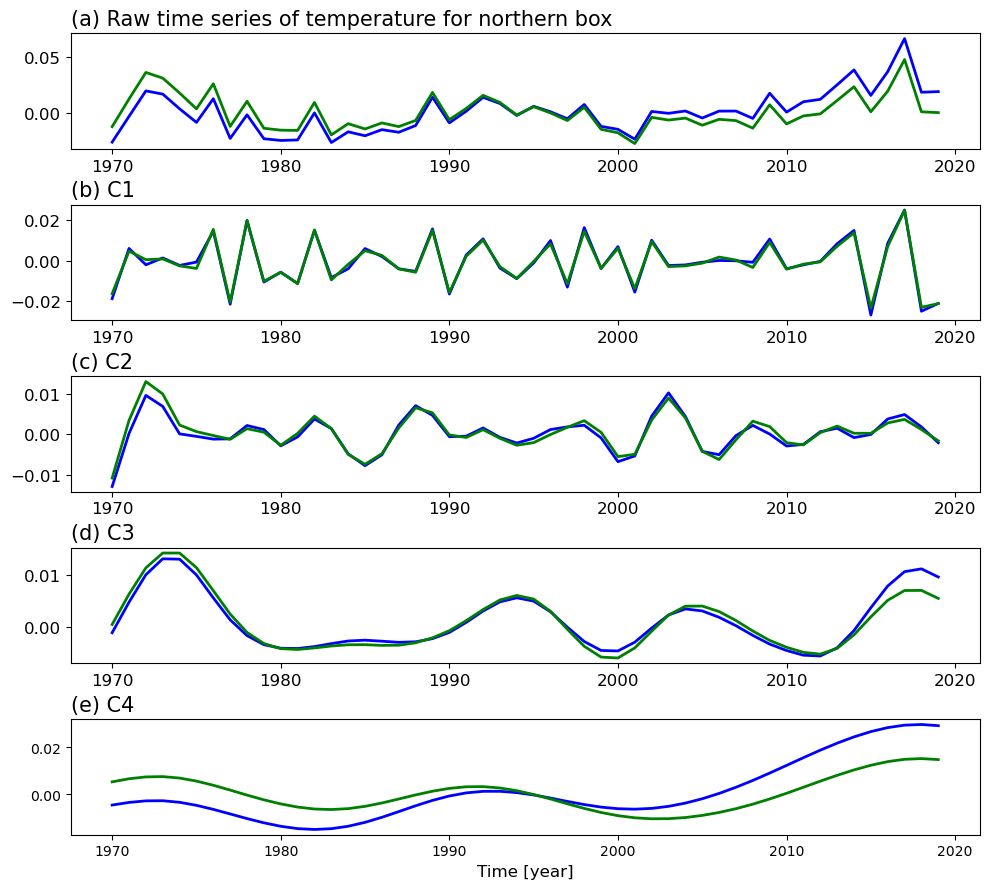

In [16]:
import matplotlib.pyplot as plt
t = np.arange(1970,2020,1)
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 9))
fontsize = 15
#plot time signal:
axs[0].set_title("(a) Raw time series of temperature for northern box", loc='left', fontsize=fontsize)
axs[0].plot(t, assi[0,:], 'b', linewidth=2)
axs[0].plot(t, hind[0,:], '-', color='green', linewidth=2, markersize=10, label = 'Raw')

# axs[0].set_xticklabels([])
plt.title('(a)', loc='left', fontsize=fontsize)

axs[1].plot(t, assi[1,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[1].plot(t, hind[1,:], '-', color='green', linewidth=2, markersize=10)
axs[1].set_title("(b) C1", loc='left', fontsize=fontsize)
# axs[1].set_ylim(-0.05, 0.05)   

axs[2].plot(t, assi[2,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[2].plot(t, hind[2,:], '-', color='green', linewidth=2, markersize=10)
axs[2].set_title("(c) C2", loc='left', fontsize=fontsize)

axs[3].plot(t, assi[3,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[3].plot(t, hind[3,:], '-', color='green', linewidth=2, markersize=10)
axs[3].set_title("(d) C3", loc='left', fontsize=fontsize)

axs[4].plot(t, assi[4,:], '-', color='blue', linewidth=2, markersize=10, label = 'raw')
axs[4].plot(t, hind[4,:], '-', color='green', linewidth=2, markersize=10)
axs[4].set_title("(e) C4", loc='left', fontsize=fontsize)
# axs[4].set_ylim(-0.05, 0.05)

axs[4].set_xlabel("Time [year]", fontsize='12')

axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)
axs[2].tick_params(axis='both', labelsize=12)
axs[3].tick_params(axis='both', labelsize=12)



# axs[6].set_ylim(-0.05, 0.05)
plt.tight_layout(h_pad=0.5, w_pad=None)

fig.savefig('/work/uo1075/u241321/results/results.pdf',bbox_inches='tight')

plt.show()